In [5]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import pandas as pd
import yfinance as yf
import math
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data = pd.read_csv('returns.csv', index_col = 0)
data.index = pd.to_datetime(data.index)
data = data[1:]
data.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-03,NaN,0.017936,NaN,NaN,-0.012308,NaN,NaN,NaN,0.005435,0.000000,...,NaN,0.008474,NaN,-0.005971,0.000000,NaN,NaN,NaN,NaN,NaN
1985-01-04,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,...,NaN,-0.008403,NaN,0.000000,-0.005618,NaN,NaN,NaN,NaN,NaN
1985-01-07,NaN,-0.004405,NaN,NaN,0.012461,NaN,NaN,NaN,0.010811,0.020135,...,NaN,0.000000,NaN,-0.006006,0.008474,NaN,NaN,NaN,NaN,NaN
1985-01-08,NaN,-0.008849,NaN,NaN,-0.006154,NaN,NaN,NaN,-0.021390,0.000000,...,NaN,0.000000,NaN,-0.003021,0.000000,NaN,NaN,NaN,NaN,NaN
1985-01-09,NaN,0.026784,NaN,NaN,-0.001872,NaN,NaN,NaN,0.005464,0.000000,...,NaN,-0.004237,NaN,0.006060,0.002801,NaN,NaN,NaN,NaN,NaN


In [10]:
# load FF
ff = pd.read_csv("data/ff_daily.csv")

ff["Date"] = pd.to_datetime(ff["Date"].astype(str), format='%Y%m%d')
ff = ff.set_index("Date")
ff = ff / 100 # convert to percentage
ff

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1926-07-02,0.0045,-0.0033,-0.0006,0.00009
1926-07-06,0.0017,0.0030,-0.0039,0.00009
1926-07-07,0.0009,-0.0058,0.0002,0.00009
1926-07-08,0.0021,-0.0038,0.0019,0.00009
...,...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017


In [11]:
common = data.index.intersection(ff.index)
ff = ff.loc[common]

xreturns = data.subtract(ff['RF'], axis = 0)
xreturns

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-03,NaN,0.017646,NaN,NaN,-0.012598,NaN,NaN,NaN,0.005145,-0.000290,...,NaN,0.008184,NaN,-0.006261,-0.000290,NaN,NaN,NaN,NaN,NaN
1985-01-04,NaN,-0.000290,NaN,NaN,-0.000290,NaN,NaN,NaN,-0.000290,-0.000290,...,NaN,-0.008693,NaN,-0.000290,-0.005908,NaN,NaN,NaN,NaN,NaN
1985-01-07,NaN,-0.004695,NaN,NaN,0.012171,NaN,NaN,NaN,0.010521,0.019845,...,NaN,-0.000290,NaN,-0.006296,0.008184,NaN,NaN,NaN,NaN,NaN
1985-01-08,NaN,-0.009139,NaN,NaN,-0.006444,NaN,NaN,NaN,-0.021680,-0.000290,...,NaN,-0.000290,NaN,-0.003311,-0.000290,NaN,NaN,NaN,NaN,NaN
1985-01-09,NaN,0.026494,NaN,NaN,-0.002162,NaN,NaN,NaN,0.005174,-0.000290,...,NaN,-0.004527,NaN,0.005770,0.002511,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.004324,-0.005758,0.015191,-0.009289,0.004860,-0.004525,0.016134,-0.002526,0.003968,0.007262,...,0.007090,0.007119,-0.003517,0.008404,0.001559,0.008296,-0.000056,0.007395,0.015244,0.001434
2023-12-26,0.001509,-0.003051,-0.002275,-0.014983,0.001624,-0.004679,-0.003088,-0.001028,0.008770,0.012804,...,-0.004375,0.007648,0.006204,0.002851,0.002047,0.008490,0.001790,0.008932,0.022395,0.002457
2023-12-27,-0.000138,0.000308,0.001471,-0.015853,0.004917,0.000198,0.000893,-0.003854,0.002204,-0.003249,...,0.000668,0.003544,-0.004276,-0.003288,-0.004909,0.006479,0.004243,-0.002598,0.000843,0.006951


In [12]:
monthly_dates = data.resample("MS").last().index
monthly_dates

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=468, freq='MS')

In [13]:
momentum = pd.DataFrame()

for month in monthly_dates[13:]: # 12M excluding last month MOM12-2
    end = (month - pd.DateOffset(months = 2)) + MonthEnd(0)
    beg = (month - pd.DateOffset(months = 13)).replace(day = 1)
    
    # print(month, ": ", beg, "-", end)    
    
    retursn2Minus12 = xreturns[(xreturns.index >= beg) & (xreturns.index <= end)]
    retursn2Minus12 = retursn2Minus12 + 1
    mom = retursn2Minus12.prod() - 1

    momentum[month] = mom

momentum = momentum.T

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/660558523.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  momentum[month] = mom
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/660558523.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  momentum[month] = mom
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/660558523.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [55]:
momentum_rank = momentum.rank(axis=1, method='first', ascending=False).astype(int)
momentum_rank
# momentum

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
1986-02-01,180,496,181,182,24,183,184,185,167,68,...,460,176,461,121,115,462,463,464,465,466
1986-03-01,152,491,153,154,50,155,156,157,471,81,...,432,149,433,103,136,434,435,436,437,438
1986-04-01,170,470,171,172,69,173,174,175,459,70,...,450,132,451,85,145,452,453,454,455,456
1986-05-01,180,148,181,182,53,183,184,185,476,93,...,458,109,459,101,159,460,461,462,463,464
1986-06-01,193,104,194,195,36,196,197,198,40,120,...,470,123,471,100,175,472,473,474,475,476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,339,94,427,90,337,38,258,126,117,368,...,203,311,19,433,149,82,173,107,356,350
2023-09-01,411,141,256,71,291,16,279,82,166,283,...,303,350,19,432,195,126,194,114,446,295
2023-10-01,368,172,224,203,312,18,217,44,161,393,...,319,320,17,469,173,210,187,232,403,156
2023-11-01,413,181,253,147,361,19,209,16,166,400,...,325,271,65,415,96,326,221,303,428,233


In [75]:
import math

def top10_long_short_equal_weight(row):
    ten_percent = math.floor(len(row) * 0.10)
    top = row.nlargest(ten_percent).index
    bot = row.nsmallest(ten_percent).index
    weight = pd.Series(0, index = row.index)
    weight[top] = 1 / ten_percent
    weight[bot] = -1 / ten_percent
    return weight

In [76]:
import math

def top10_long_equal_weight(row):
    ten_percent = math.floor(len(row) * 0.10)
    top = row.nlargest(ten_percent).index
    weight = pd.Series(0, index = row.index)
    weight[top] = 1 / ten_percent
    return weight

In [77]:
weights_long = momentum.apply(top10_long_equal_weight, axis = 1)
weights_long_short = momentum.apply(top10_long_short_equal_weight, axis = 1)

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/2565044896.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight[top] = 1 / ten_percent
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/2565044896.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight[top] = 1 / ten_percent
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/2565044896.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight[top] = 1 / ten_

In [78]:
weights_long_short

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
1986-02-01,-0.02,-0.02,-0.02,-0.02,0.02,-0.02,-0.02,-0.02,0.00,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1986-03-01,0.00,-0.02,0.00,0.00,0.02,0.00,0.00,0.00,-0.02,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1986-04-01,-0.02,-0.02,-0.02,-0.02,0.00,-0.02,0.00,0.00,-0.02,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1986-05-01,-0.02,0.00,-0.02,-0.02,0.00,-0.02,-0.02,-0.02,-0.02,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1986-06-01,-0.02,0.00,-0.02,-0.02,0.02,-0.02,-0.02,-0.02,0.02,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.0,...,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.0,...,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.0,...,0.0,0.0,0.02,-0.02,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
portfolio_long = pd.DataFrame()

for month in weights_long.index:
    beg = month
    end = beg + MonthEnd(0)
    ret_month = xreturns.loc[beg:end] # filter the monthly returns for this period
    cum_month = (1 + ret_month).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_month= cum_month.shift(1)
    cum_month.iloc[0] = 1

    ini_weight = weights_long.loc[month] # get initial weights for the period
    month_weights = cum_month.multiply(ini_weight, axis=1)
    
    ret_portfolio = (month_weights * ret_month).sum(axis = 1)
    portfolio_long = pd.concat([portfolio_long, ret_portfolio])
    
portfolio_long.columns = ["Portfolio Long Only"]
portfolio_long

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/3369543155.py:17: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio_long = pd.concat([portfolio_long, ret_portfolio])


,Portfolio Long Only
1986-02-03,0.009468
1986-02-04,-0.000155
1986-02-05,-0.002390
1986-02-06,0.008347
1986-02-07,0.002100
...,...
2023-12-22,-0.001681
2023-12-26,0.005994
2023-12-27,0.001535
2023-12-28,-0.000158


In [94]:
portfolio_long_short = pd.DataFrame()

for month in weights_long_short.index:
    beg = month
    end = beg + MonthEnd(0)
    ret_month = xreturns.loc[beg:end] # filter the monthly returns for this period
    cum_month = (1 + ret_month).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_month= cum_month.shift(1)
    cum_month.iloc[0] = 1

    ini_weight = weights_long_short.loc[month] # get initial weights for the period
    month_weights = cum_month.multiply(ini_weight, axis=1)
    
    ret_portfolio = (month_weights * ret_month).sum(axis = 1)
    portfolio_long_short = pd.concat([portfolio_long_short, ret_portfolio])
    
portfolio_long_short.columns = ["Portfolio Long Short"]
portfolio_long_short

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/898825086.py:17: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio_long_short = pd.concat([portfolio_long_short, ret_portfolio])


,Portfolio Long Short
1986-02-03,0.010268
1986-02-04,-0.001757
1986-02-05,-0.008564
1986-02-06,0.002214
1986-02-07,0.001362
...,...
2023-12-22,-0.006215
2023-12-26,-0.004493
2023-12-27,0.000143
2023-12-28,-0.002533


In [95]:
mupor_long = portfolio_long.mean() * 252
sdpor_long = portfolio_long.std() * np.sqrt(252)
srpor_long = mupor_long / sdpor_long

print(f"Mu: {mupor_long[0]}")
print(f"Std: {sdpor_long[0]}")
print(f"Sharpe: {srpor_long[0]}")

Mu: 0.20553838393918947
Std: 0.2195417379021286
Sharpe: 0.9362155274129158


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/396614015.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mu: {mupor_long[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/396614015.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Std: {sdpor_long[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/396614015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [96]:
mupor_long_short = portfolio_long_short.mean() * 252
sdpor_long_short = portfolio_long_short.std() * np.sqrt(252)
srpor_long_short = mupor_long_short / sdpor_long_short

print(f"Mu: {mupor_long_short[0]}")
print(f"Std: {sdpor_long_short[0]}")
print(f"Sharpe: {srpor_long_short[0]}")

Mu: 0.004259376123817709
Std: 0.23911375778763502
Sharpe: 0.01781317881173782


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/1902394199.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mu: {mupor_long_short[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/1902394199.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Std: {sdpor_long_short[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/1902394199.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

In [97]:
port_common = portfolio_long.index.intersection(ff.index)
port_ff = ff.loc[port_common]
port_ff

,Mkt-RF,SMB,HML,RF
1986-02-03,0.0093,-0.0053,-0.0060,0.00028
1986-02-04,-0.0025,0.0013,-0.0031,0.00028
1986-02-05,0.0007,0.0000,-0.0056,0.00028
1986-02-06,0.0026,0.0019,-0.0009,0.00028
1986-02-07,0.0049,0.0009,-0.0034,0.00028
...,...,...,...,...
2023-12-22,0.0020,0.0064,0.0010,0.00021
2023-12-26,0.0048,0.0071,0.0043,0.00021
2023-12-27,0.0016,0.0014,0.0010,0.00021
2023-12-28,-0.0001,-0.0036,0.0002,0.00021


In [98]:
# regression
X = port_ff[['Mkt-RF', 'SMB', 'HML']]
y = portfolio_long

model = LinearRegression().fit(X, y)
alpha = model.intercept_
betas = model.coef_

In [100]:
print(f"Mu: {mupor_long[0]}")
print(f"Std: {sdpor_long[0]}")
print(f"Sharpe: {srpor_long[0]}")
print(f"Alpha Ann: {alpha[0] * 252}")
print(f"Beta to MKT: {betas[0][0]}")
print(f"Beta to SMB: {betas[0][1]}")
print(f"Beta to HML: {betas[0][2]}")

Mu: 0.20553838393918947
Std: 0.2195417379021286
Sharpe: 0.9362155274129158
Alpha Ann: 0.1196339820738772
Beta to MKT: 1.0191531359867512
Beta to SMB: 0.31997944520984556
Beta to HML: -0.2292828652475549


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/337750938.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mu: {mupor_long[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/337750938.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Std: {sdpor_long[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/337750938.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [101]:
# regression
X = port_ff[['Mkt-RF', 'SMB', 'HML']]
y = portfolio_long_short

model = LinearRegression().fit(X, y)
alpha = model.intercept_
betas = model.coef_

In [102]:
print(f"Mu: {mupor_long_short[0]}")
print(f"Std: {sdpor_long_short[0]}")
print(f"Sharpe: {srpor_long_short[0]}")
print(f"Alpha Ann: {alpha[0] * 252}")
print(f"Beta to MKT: {betas[0][0]}")
print(f"Beta to SMB: {betas[0][1]}")
print(f"Beta to HML: {betas[0][2]}")

Mu: 0.004259376123817709
Std: 0.23911375778763502
Sharpe: 0.01781317881173782
Alpha Ann: 0.030335188525237432
Beta to MKT: -0.10505038558371245
Beta to SMB: -0.04264339997735145
Beta to HML: -0.8005143149400913


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/2557064393.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mu: {mupor_long_short[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/2557064393.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Std: {sdpor_long_short[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_25219/2557064393.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

<Axes: >

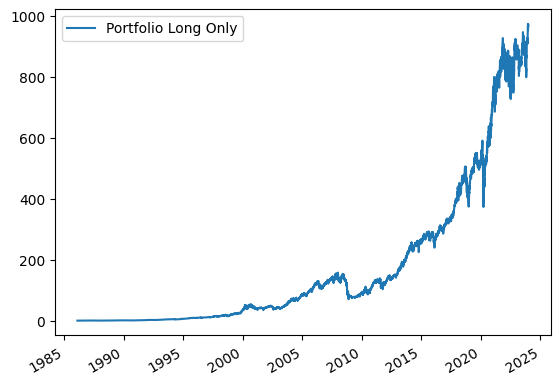

In [103]:
cum_returns = (1 + portfolio_long).cumprod()
cum_returns.plot()

<Axes: >

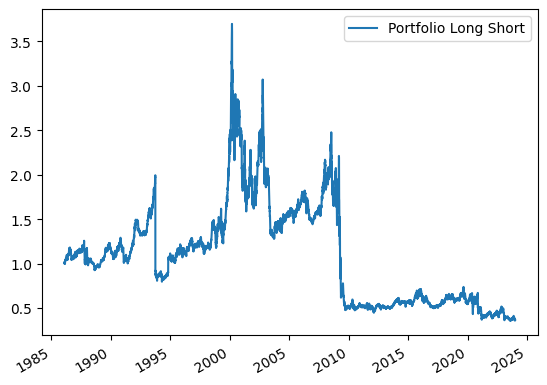

In [106]:
cum_returns = (1 + portfolio_long_short).cumprod()
cum_returns.plot()

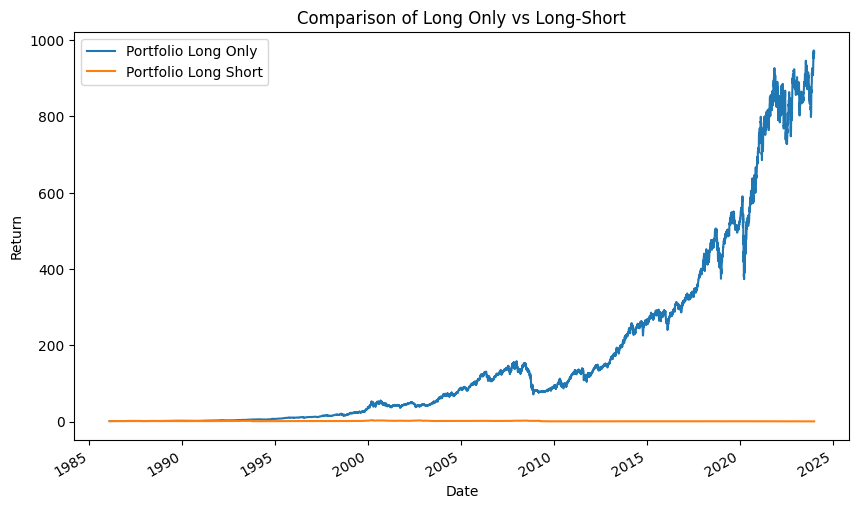

In [105]:
cum_returns_long = (1 + portfolio_long).cumprod()
cum_returns_long_short = (1 + portfolio_long_short).cumprod()

ax = cum_returns_long.plot(label='Long Only', figsize=(10, 6))
cum_returns_long_short.plot(ax=ax, label='Long & Short')

ax.set_title('Comparison of Long Only vs Long-Short')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.legend()
plt.show()